In [1]:
# python libraries
import os
import sys
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
import dataclasses
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
import torchvision
from torch import nn
from torchvision import (
    transforms,
    datasets
    )
from torch.utils.data import DataLoader

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper

[INFO] Installing the torchmetrics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 20.6 MB/s eta 0:00:00
[INFO] Downloading the helper function from github


# LeNet

In [2]:
class LeNet(helper.Classifier):
    def __init__(self,lr,num_classes) -> None:
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6,kernel_size=(5,5),padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.LazyConv2d(out_channels=16,kernel_size=5), #! There is no padding done 2nd conv layer
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=120),
            nn.Sigmoid(),
            nn.LazyLinear(out_features=84),
            nn.Sigmoid(),
            nn.LazyLinear(out_features=self.num_classes)
        )

In [3]:
lenet = LeNet(lr=0.01,num_classes=10)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
lenet.layer_summary(input_shape=(1,1,28,28))

Conv2d          output shape :(1, 6, 28, 28)
Sigmoid         output shape :(1, 6, 28, 28)
AvgPool2d       output shape :(1, 6, 14, 14)
Conv2d          output shape :(1, 16, 10, 10)
Sigmoid         output shape :(1, 16, 10, 10)
AvgPool2d       output shape :(1, 16, 5, 5)
Flatten         output shape :(1, 400)
Linear          output shape :(1, 120)
Sigmoid         output shape :(1, 120)
Linear          output shape :(1, 84)
Sigmoid         output shape :(1, 84)
Linear          output shape :(1, 10)


In [5]:
def init_cnn(module):
    if isinstance(module,(nn.Linear,nn.Conv2d)):
        nn.init.xavier_uniform_(module.weight)

# Data

In [6]:
class FashionMNIST(helper.DataModule):
    def __init__(self, batch_size: int = 64, resize=(28, 28)) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.resize = resize

        transform = transforms.Compose(
            [transforms.Resize(resize), transforms.ToTensor()]
        )

        self.train = datasets.FashionMNIST(
            root=self.root, train=True, transform=transform,download=True
        )
        self.val = datasets.FashionMNIST(
            root=self.root, train=False, transform=transform,download=True
        )
        self.classes = self.train.classes
        self.class_to_idx = self.train.class_to_idx

    def text_labels(self, indices: List):
        return [self.classes[a] for a in indices]

    def get_dataloader(self, train: bool):
        data = self.train if train else self.val
        return DataLoader(
            dataset=data,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=train,
        )
    
    def visualize(self,batch:Tuple,num_rows=1,num_cols=8):
        X,y = batch
        labels = self.text_labels(y)
        helper.show_images(X.squeeze(1),num_rows=num_rows,num_cols=num_cols,titles=labels)

# Training the model

In [7]:
data = FashionMNIST(batch_size=128)
model = LeNet(lr=0.1,num_classes=len(data.classes))
model.apply_init([next(iter(data.get_dataloader(True)))[0]],init_cnn)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Training the model in cuda


  0%|          | 0/10 [00:00<?, ?it/s]

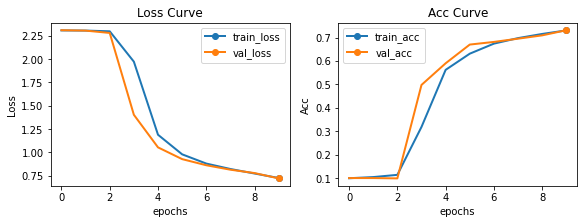

In [8]:
trainer = helper.Trainer(max_epochs=10)
trainer.fit(model,data)

# Experiments


## Exp 1
1. Replace the average pooling with max-pooling.
2. Replace the softmax layer with ReLU.

In [8]:
list(model.net.named_children())

[('0', Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))),
 ('1', Sigmoid()),
 ('2', AvgPool2d(kernel_size=2, stride=2, padding=0)),
 ('3', Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))),
 ('4', Sigmoid()),
 ('5', AvgPool2d(kernel_size=2, stride=2, padding=0)),
 ('6', Flatten(start_dim=1, end_dim=-1)),
 ('7', Linear(in_features=400, out_features=120, bias=True)),
 ('8', Sigmoid()),
 ('9', Linear(in_features=120, out_features=84, bias=True)),
 ('10', Sigmoid()),
 ('11', Linear(in_features=84, out_features=10, bias=True))]

In [9]:
def modify_model(model, changes: Dict):
    layers = nn.Sequential()
    for name, layer in model.net.named_children():
        layer_name = layer.__class__.__name__
        if layer_name in changes.keys():
            layers.add_module(
                name=name,
                module=methodcaller(changes[layer_name][0], **changes[layer_name][1])(nn),
            )
        else:
            layers.add_module(name=name, module=layer)
    return layers

In [10]:
change_dict = {"AvgPool2d":("MaxPool2d",{"kernel_size":2,"stride":2}),
               "Sigmoid":("ReLU",{})}

In [11]:
model.net = modify_model(model,change_dict)

In [12]:
model.net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

Training the model in cuda


  0%|          | 0/10 [00:00<?, ?it/s]

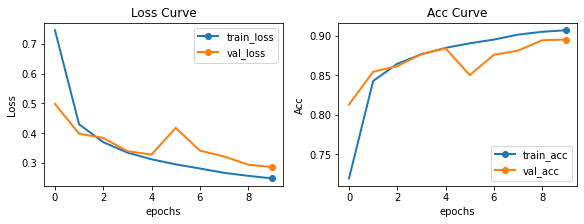

In [13]:
trainer = helper.Trainer(max_epochs=10)
trainer.fit(model,data)

## View activation

In [14]:
X,y = next(iter(data.train_dataloader()))
single_image = X[0]


In [15]:
import matplotlib.pyplot as plt
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """
    Take the image in format fo [h,w,c]
    """
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(
        nrows=num_rows, ncols=num_cols, figsize=figsize, constrained_layout=True
    )
    for i, (ax, img) in enumerate(zip(axes.ravel(), imgs)):
        try:
            img = img.detach().numpy()
        except:
            pass
        ax.imshow(img,cmap="gray")
        ax.axis("off")
        if titles:
            ax.set_title(titles[i])
    return axes

In [16]:
after_conv1 = model.net[:1](X.to(trainer.device))
after_conv1.shape

torch.Size([128, 6, 28, 28])

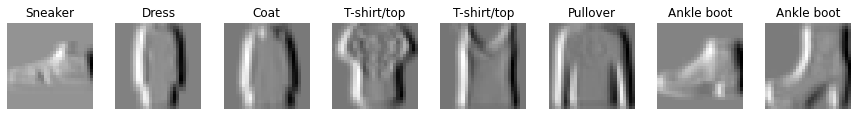

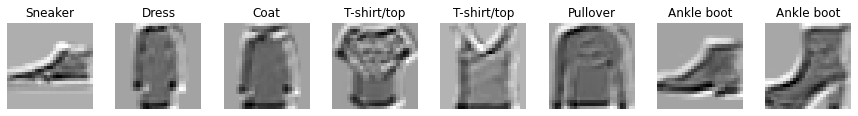

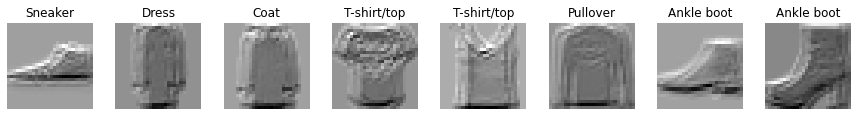

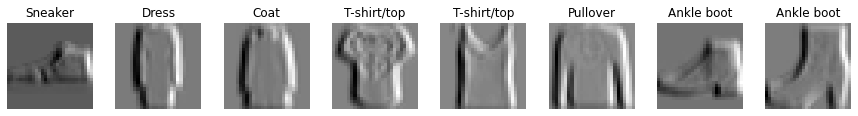

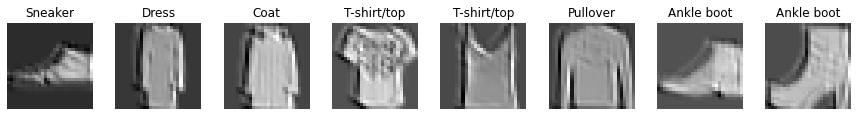

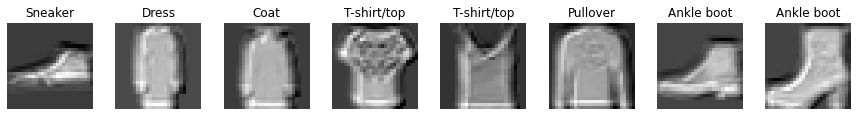

In [17]:
for layer in range(after_conv1.shape[1]):
    show_images(after_conv1.detach().cpu().numpy()[0:9,layer,:,:],1,8,data.text_labels(y))
    plt.show()

In [18]:
after_sigmoid_1 = model.net[:2](X.to(trainer.device))
after_sigmoid_1.shape

torch.Size([128, 6, 28, 28])

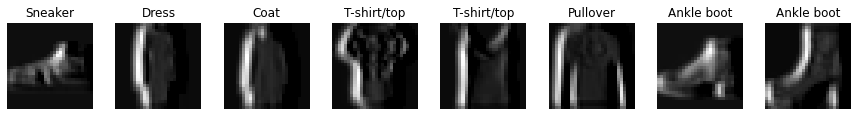

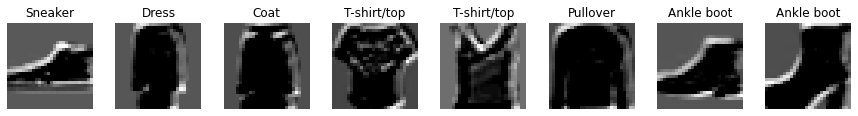

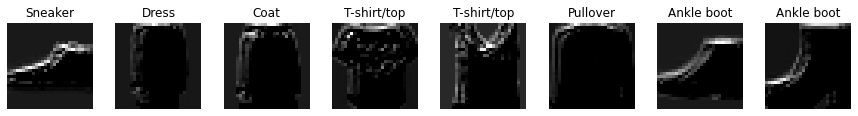

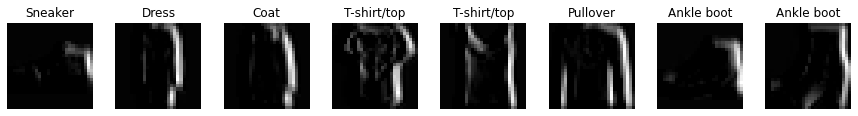

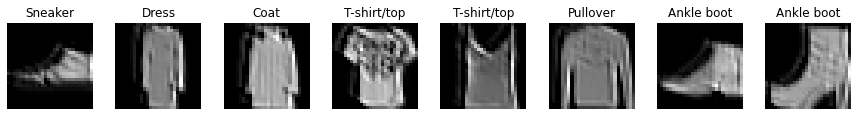

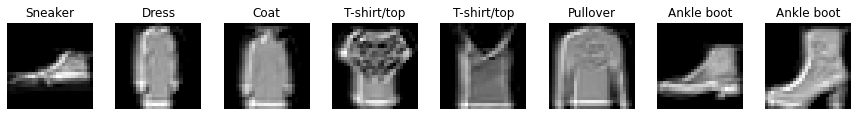

In [19]:
for layer in range(after_sigmoid_1.shape[1]):
    show_images(after_sigmoid_1.detach().cpu().numpy()[0:9,layer,:,:],1,8,data.text_labels(y))
    plt.show()

In [20]:
after_pool_1 = model.net[:3](X.to(trainer.device))
after_pool_1.shape

torch.Size([128, 6, 14, 14])

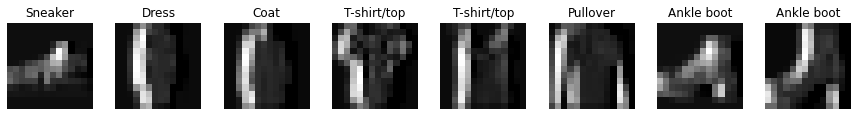

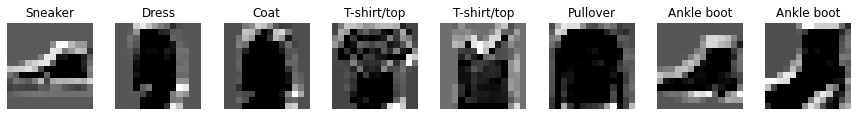

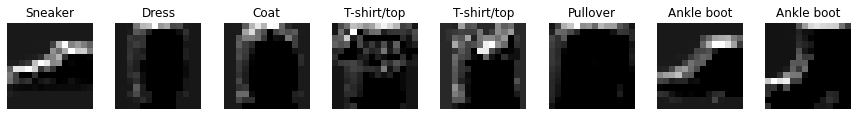

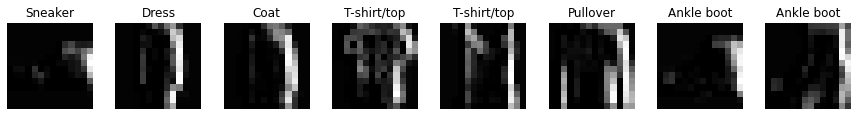

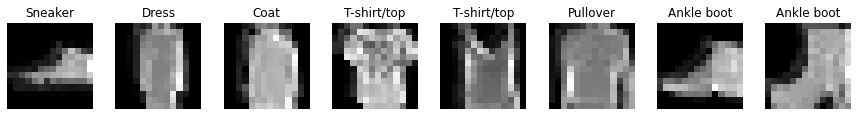

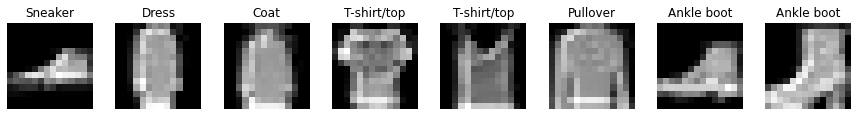

In [21]:
for layer in range(after_pool_1.shape[1]):
    show_images(after_pool_1.detach().cpu().numpy()[0:9,layer,:,:],1,8,data.text_labels(y))
    plt.show()

In [22]:
for k,v in model.named_parameters():
    print(k,tuple(v.shape))

net.0.weight (6, 1, 5, 5)
net.0.bias (6,)
net.3.weight (16, 6, 5, 5)
net.3.bias (16,)
net.7.weight (120, 400)
net.7.bias (120,)
net.9.weight (84, 120)
net.9.bias (84,)
net.11.weight (10, 84)
net.11.bias (10,)


In [23]:
parameters = list(model.parameters())
len(parameters)

10

In [24]:
parameters[2].shape

torch.Size([16, 6, 5, 5])

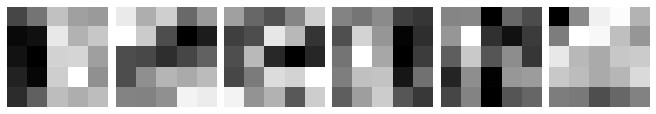

In [25]:
show_images(parameters[0].squeeze().cpu().detach().numpy(),1,6);

In [26]:
after_conv2 = model.net[:4](X.to(trainer.device))
after_conv2.shape

torch.Size([128, 16, 10, 10])

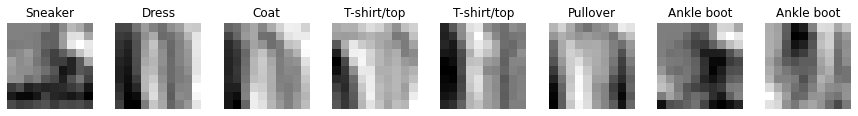

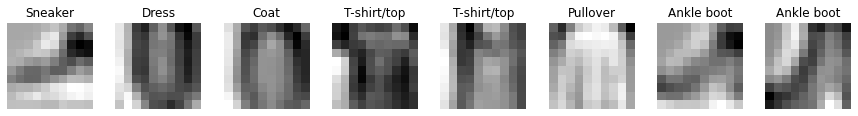

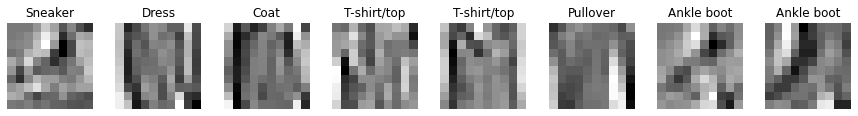

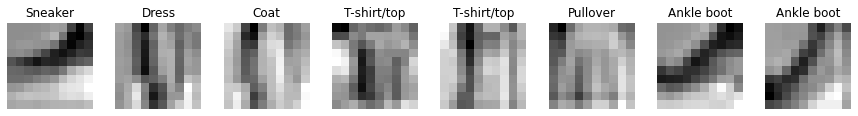

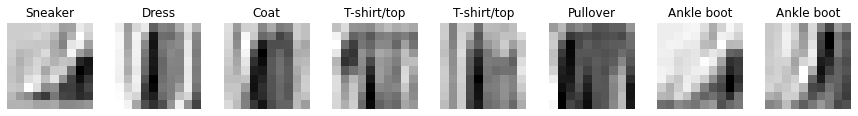

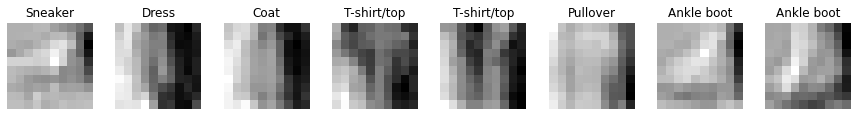

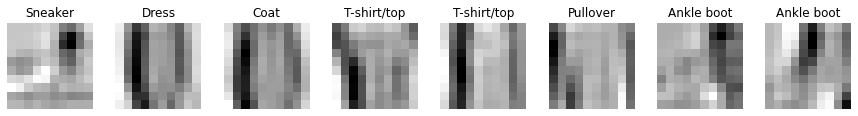

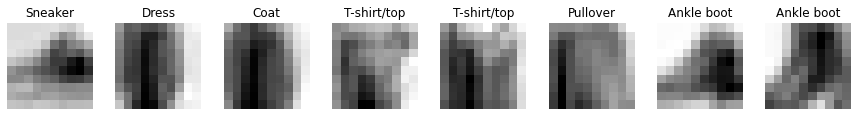

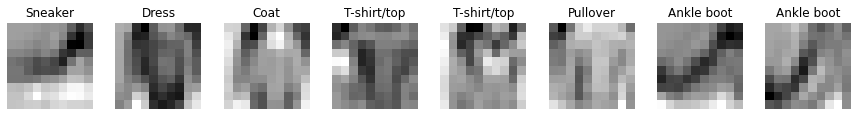

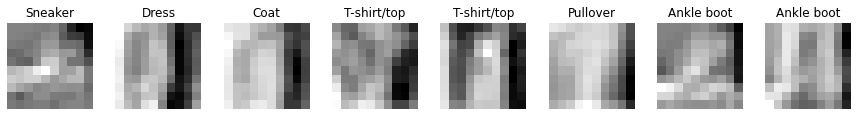

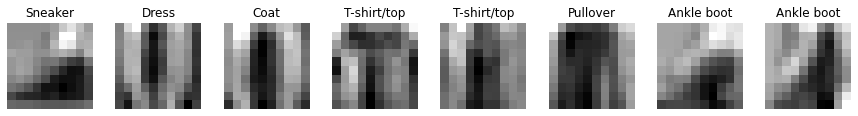

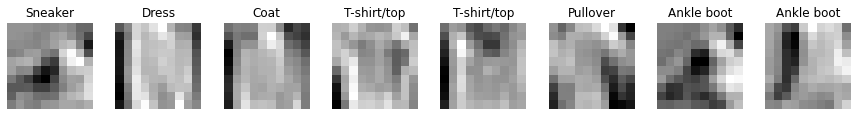

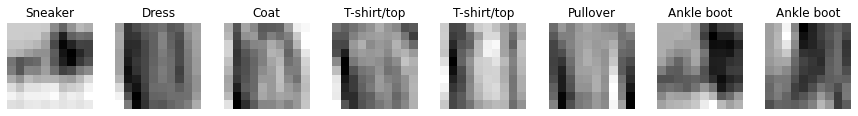

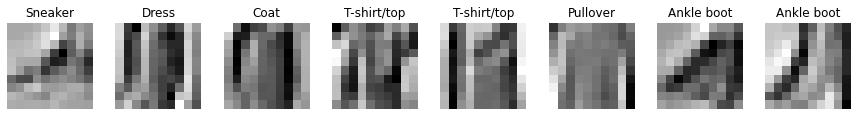

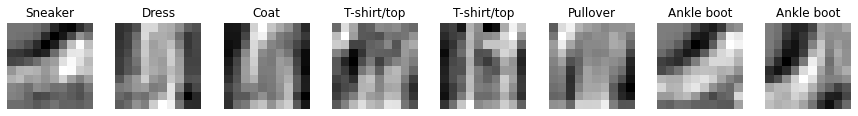

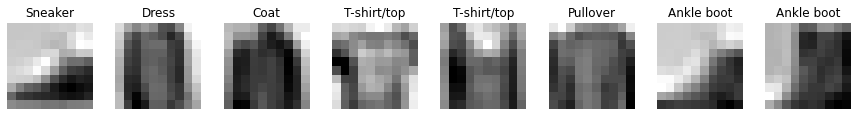

In [27]:
for layer in range(after_conv2.shape[1]):
    show_images(after_conv2.detach().cpu().numpy()[0:9,layer,:,:],1,8,data.text_labels(y))
    plt.show()

In [28]:
after_max_pool2 = model.net[:6](X.to(trainer.device))
after_max_pool2.shape

torch.Size([128, 16, 5, 5])

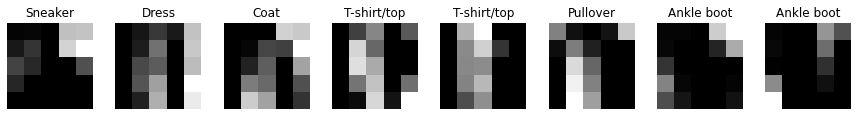

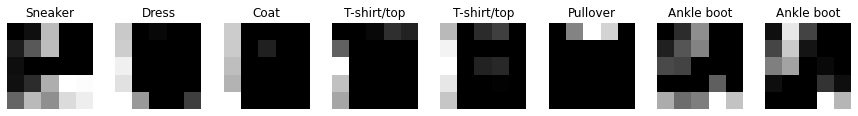

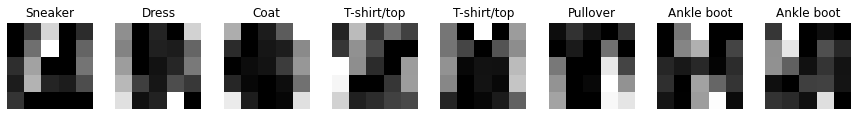

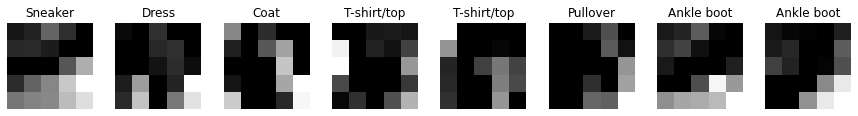

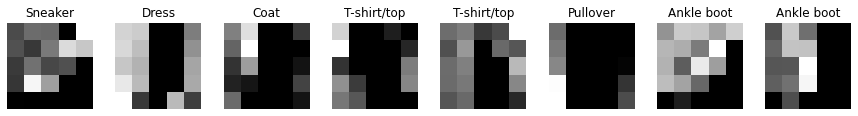

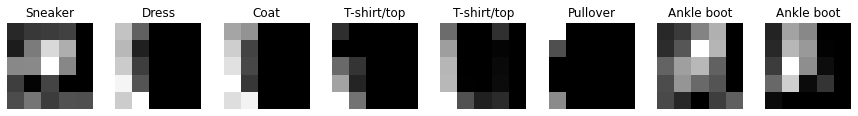

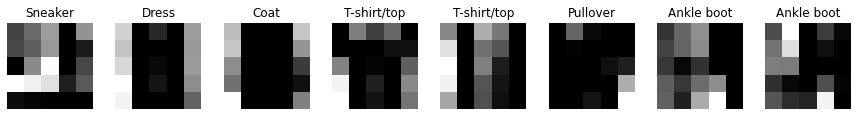

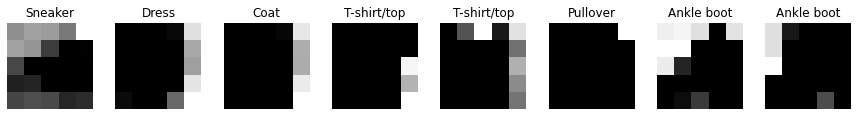

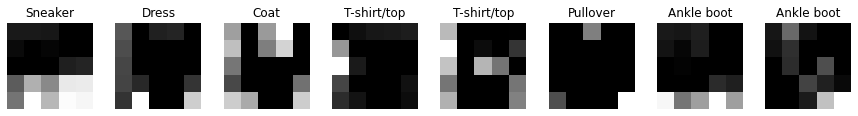

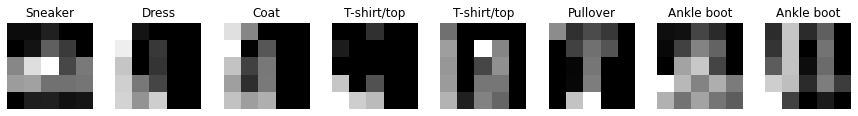

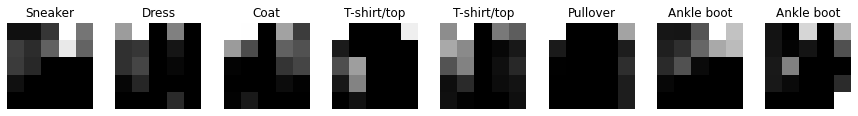

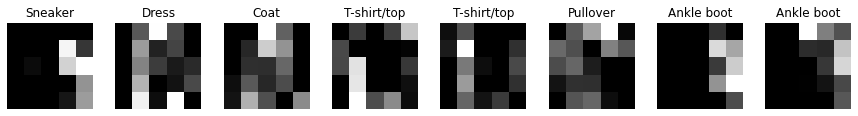

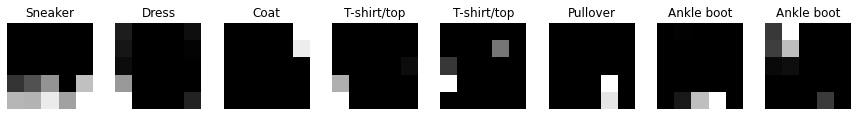

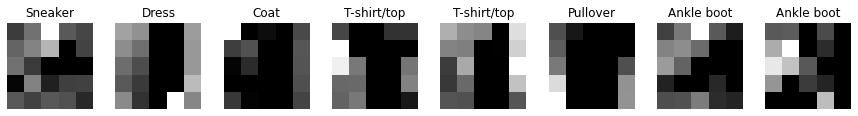

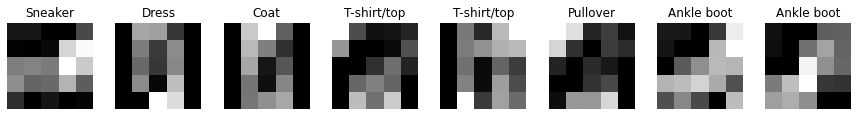

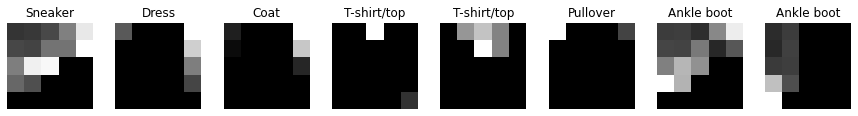

In [29]:
for layer in range(after_max_pool2.shape[1]):
    show_images(after_max_pool2.detach().cpu().numpy()[0:9,layer,:,:],1,8,data.text_labels(y))
    plt.show()

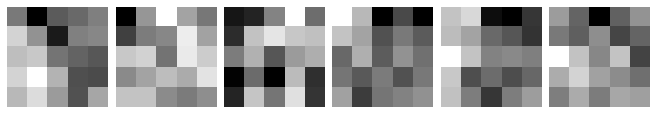

In [30]:
show_images(parameters[2].cpu().detach()[0,...].numpy(),1,6);

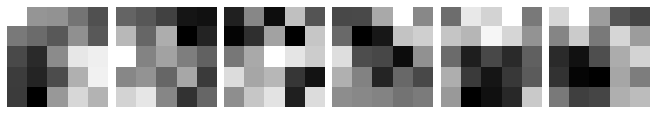

In [31]:
show_images(parameters[2].cpu().detach()[1,...].numpy(),1,6);

In [72]:
def view_channel(img,kernel,conv,sigmoid,pool,title):
    imgs = [img.squeeze(),kernel.squeeze(),conv.squeeze(),sigmoid.squeeze(),pool.squeeze()]
    show_images(imgs,1,5)
    plt.title(title)
    plt.show()

In [73]:
def visual_block(img,model,block_start,block_end,kernel_index,trainer):
    kernel = list(model.parameters())[kernel_index]
    layers = [kernel.detach().cpu().numpy()]
    for i in range(block_start,block_end):
        layers.append(model.net[:i](img.to(trainer.device)).detach().cpu().numpy())
    # for l in layers:
    #     print(l.shape)
    for filter_ in range(kernel.shape[0]):
        for channel in range(kernel.shape[1]):
            kernel_slice = np.s_[filter_,channel,:,:]
            img_slice = np.s_[filter_,:,:]
            view_channel(img,layers[0][kernel_slice],layers[1][img_slice],layers[2][img_slice],layers[3][img_slice],title=f"{filter_,channel}")
    


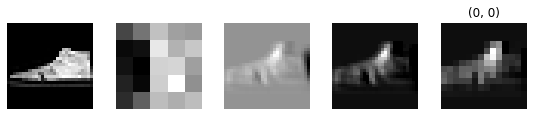

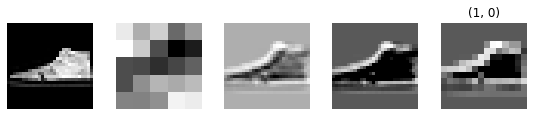

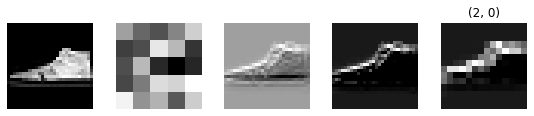

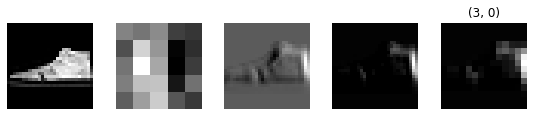

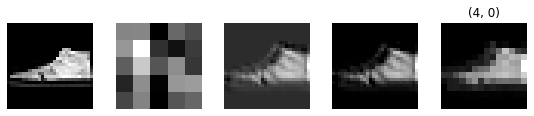

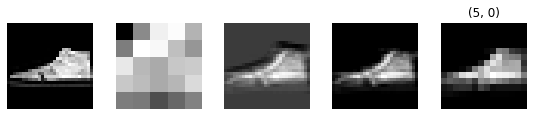

In [74]:
# this for 1st block
visual_block(single_image,model,1,4,0,trainer)


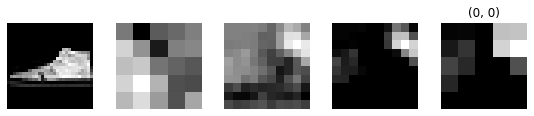

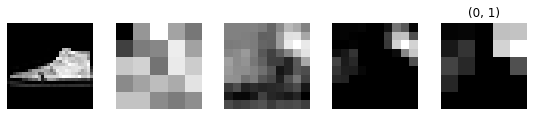

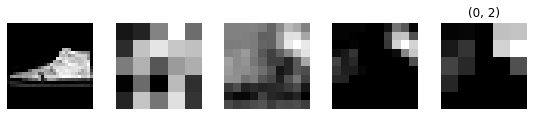

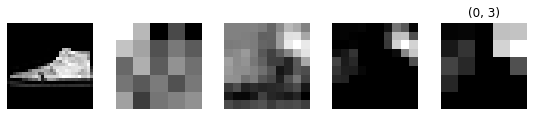

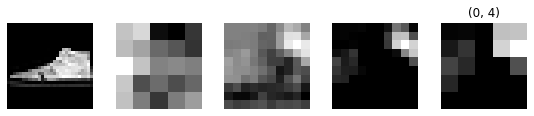

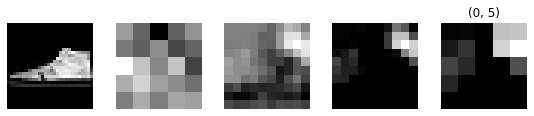

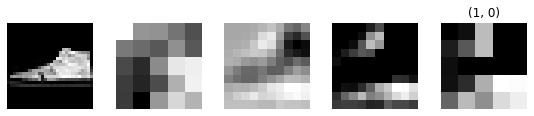

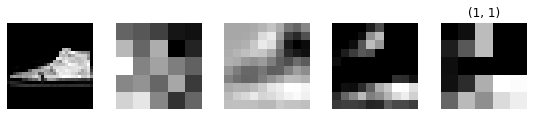

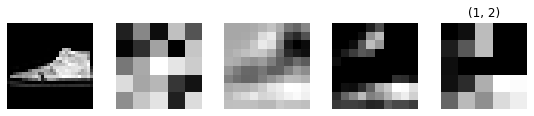

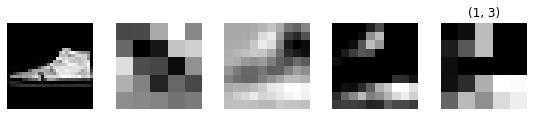

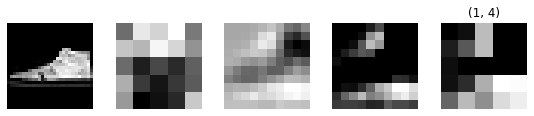

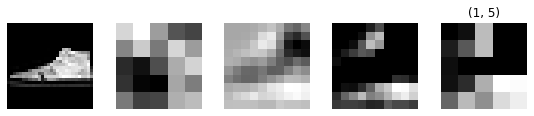

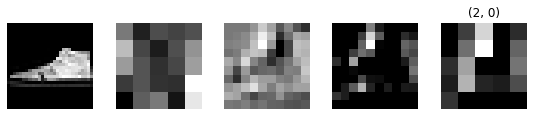

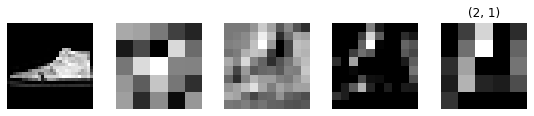

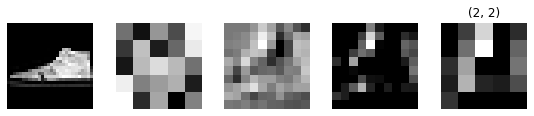

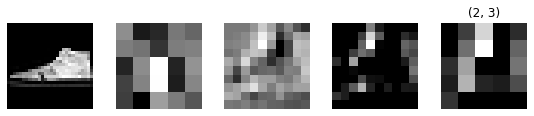

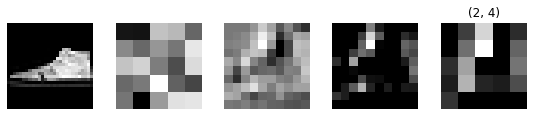

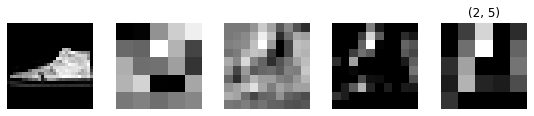

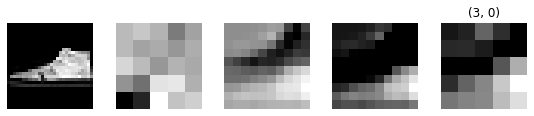

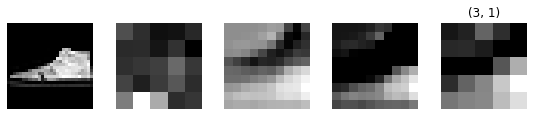

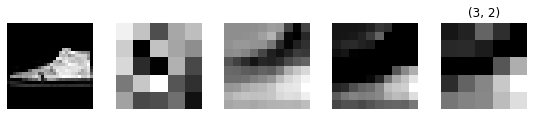

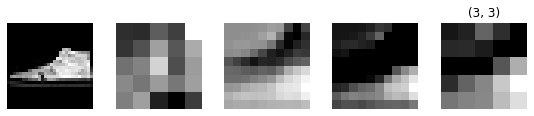

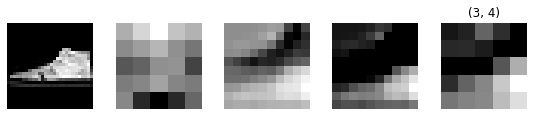

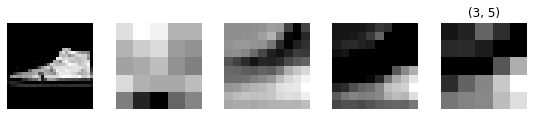

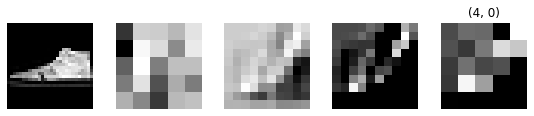

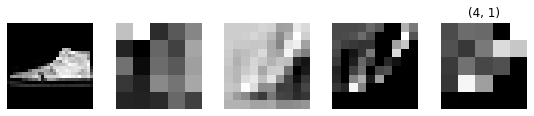

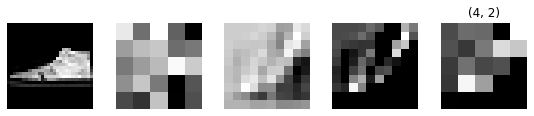

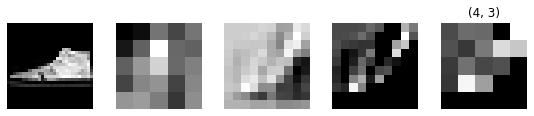

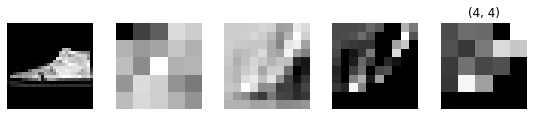

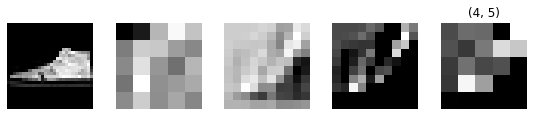

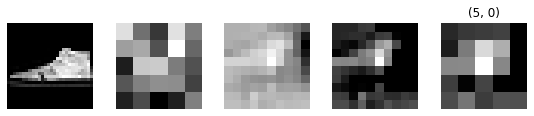

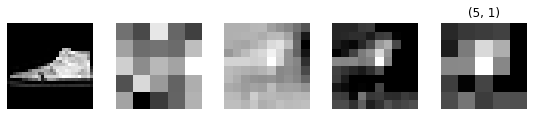

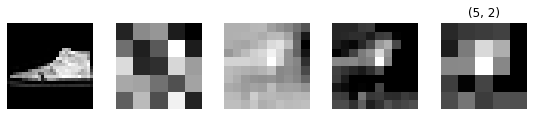

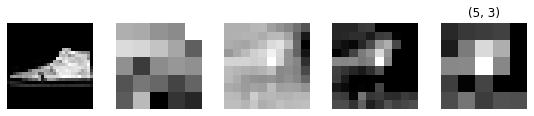

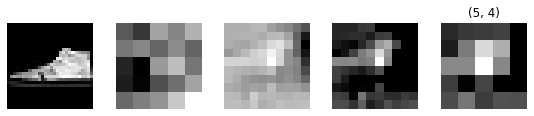

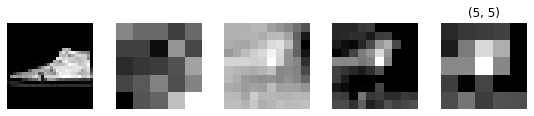

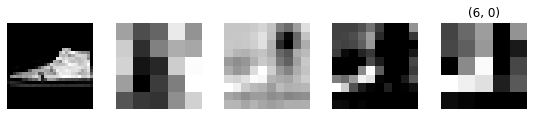

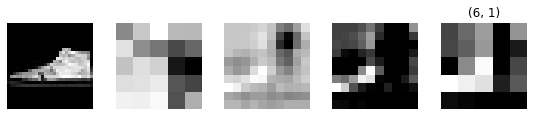

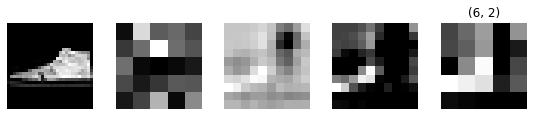

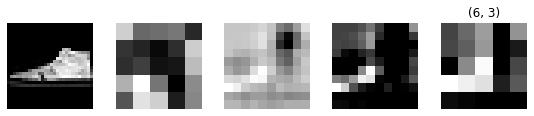

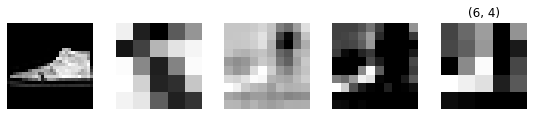

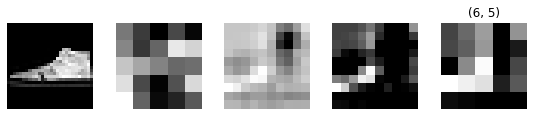

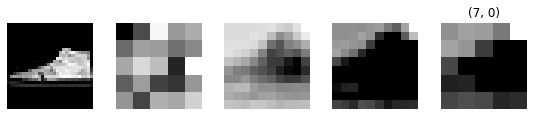

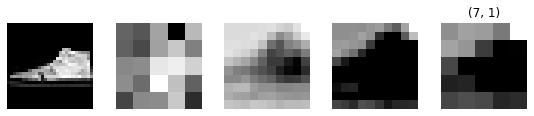

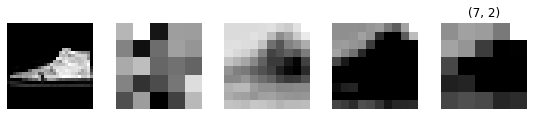

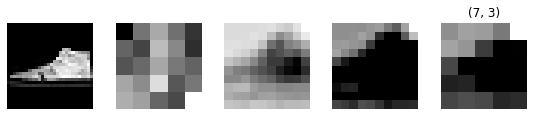

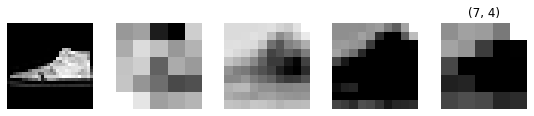

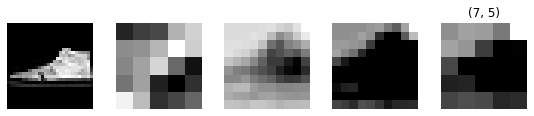

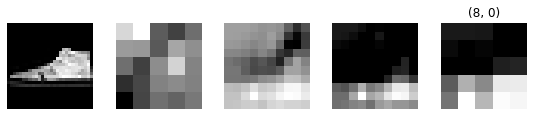

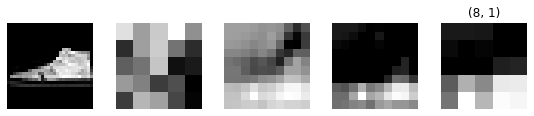

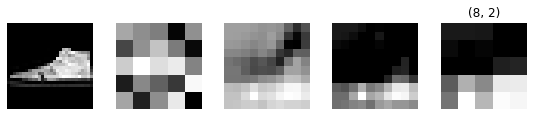

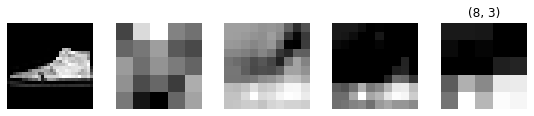

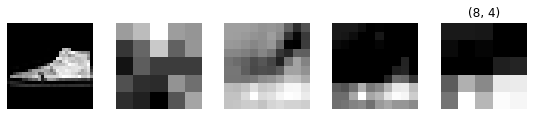

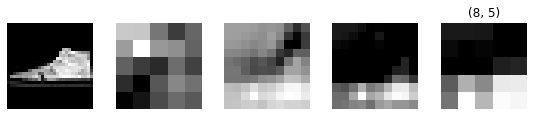

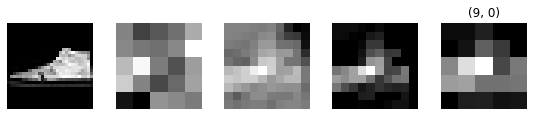

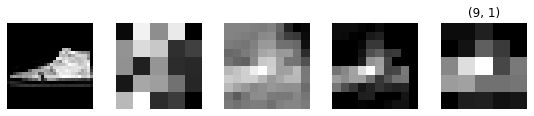

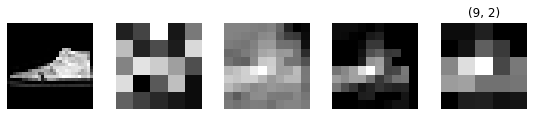

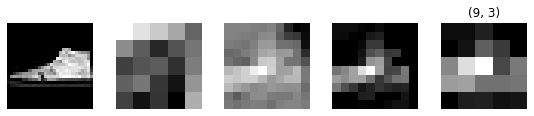

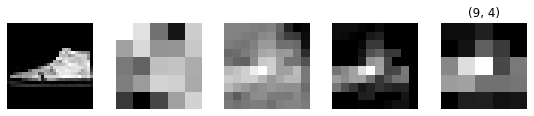

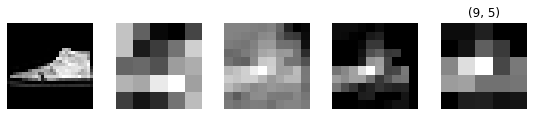

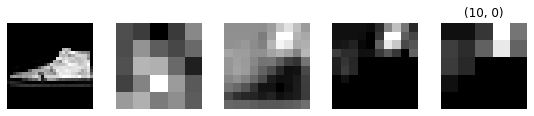

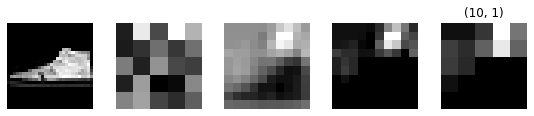

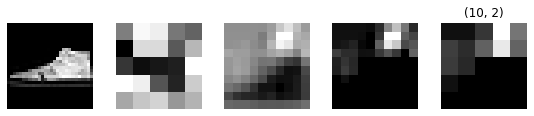

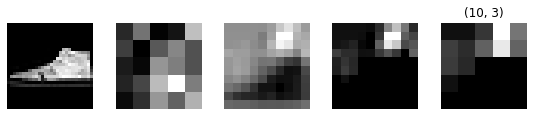

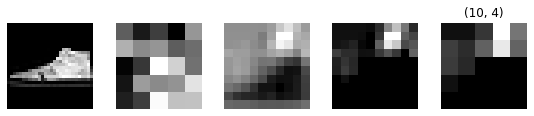

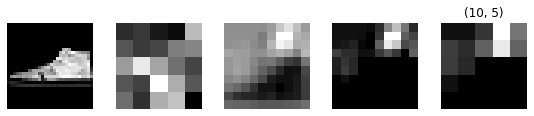

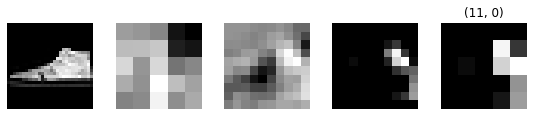

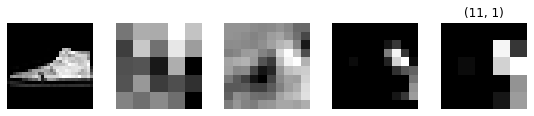

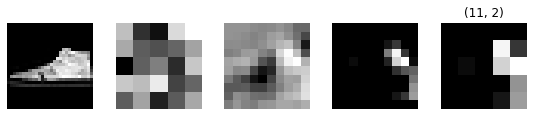

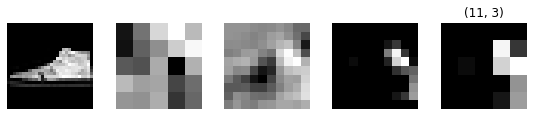

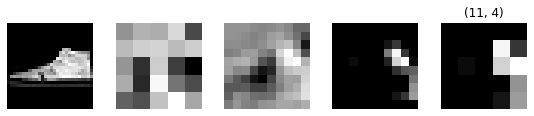

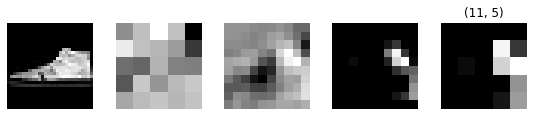

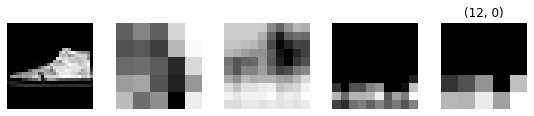

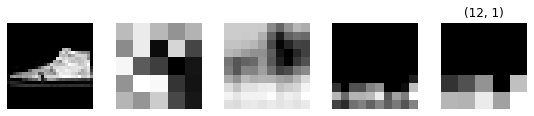

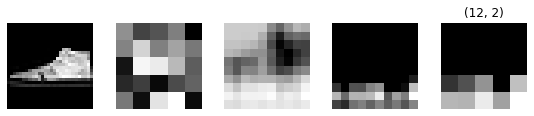

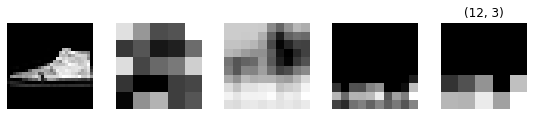

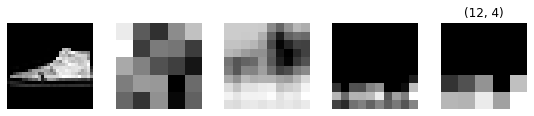

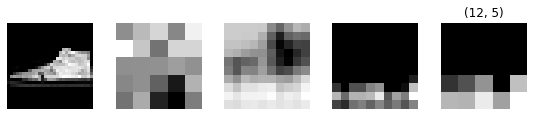

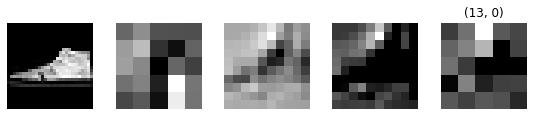

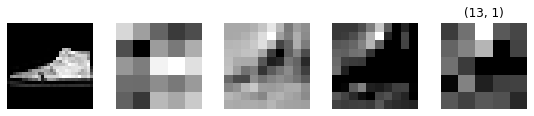

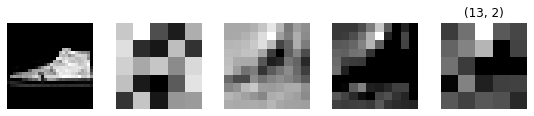

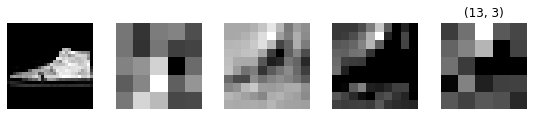

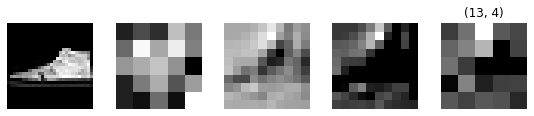

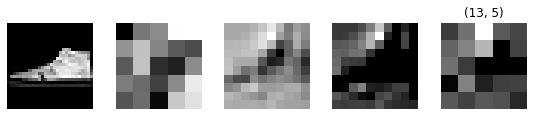

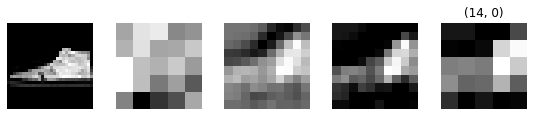

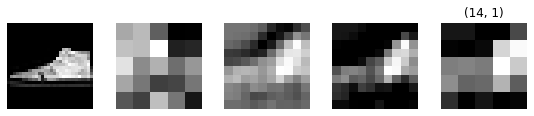

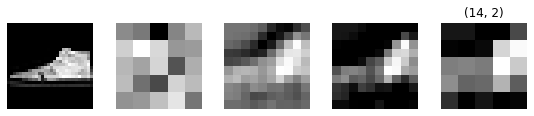

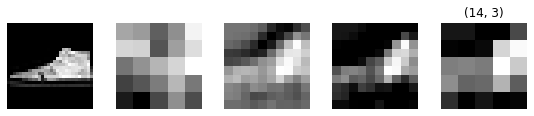

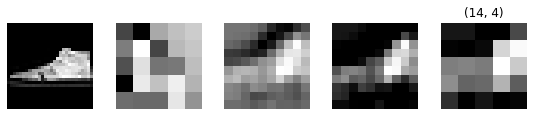

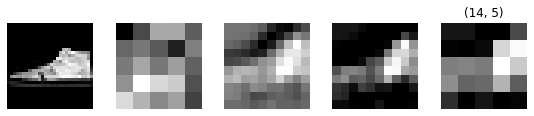

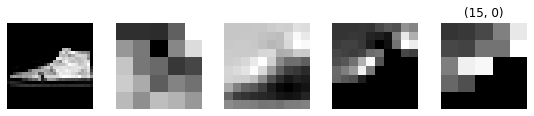

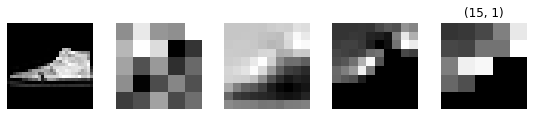

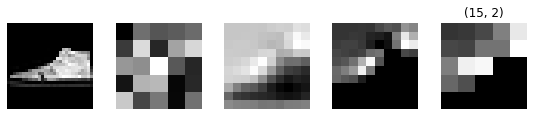

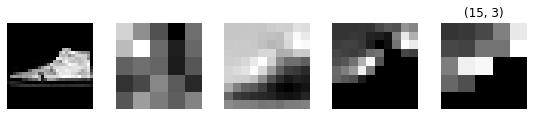

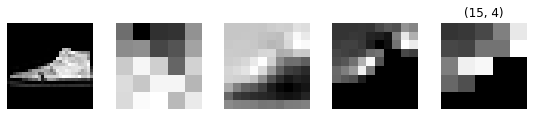

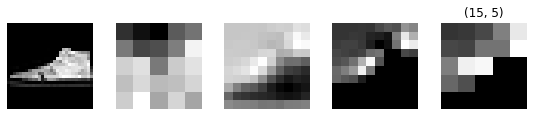

In [75]:
# this for second block
visual_block(single_image,model,4,7,2,trainer)

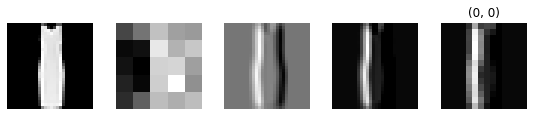

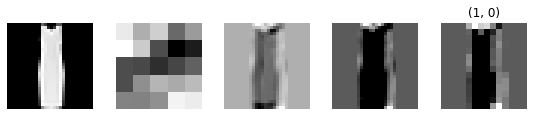

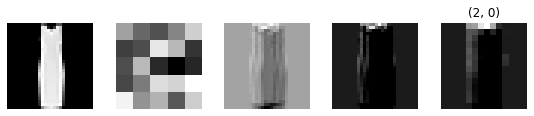

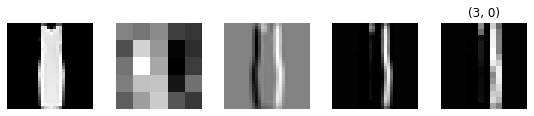

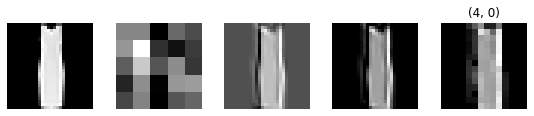

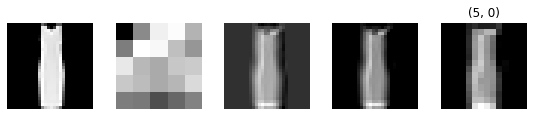

In [79]:
# this for 1st block
visual_block(X[23],model,1,4,0,trainer)

* 1st kernel ---> capture left edge part of the shirt.
* 3rd kernel ---> capture right edge part of the shirt.

This evident in the kernel itself, the kernel is shifted from left to right.

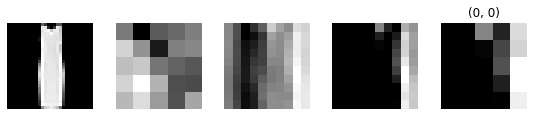

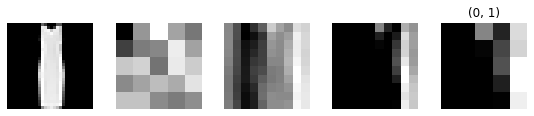

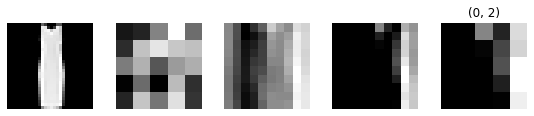

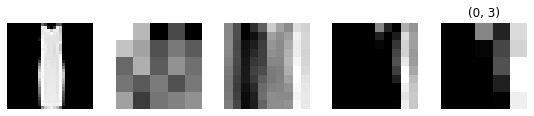

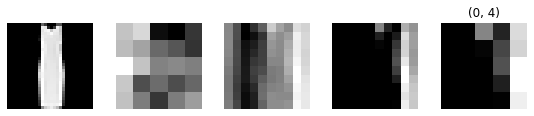

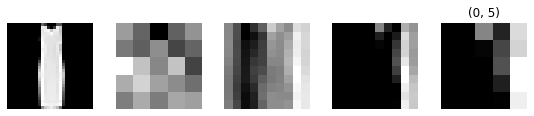

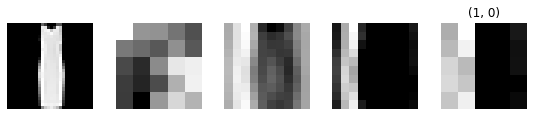

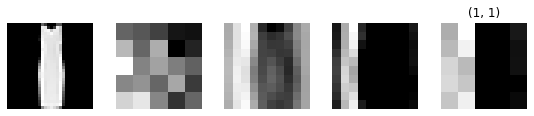

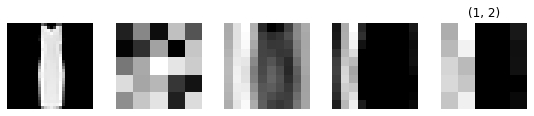

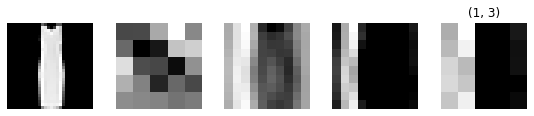

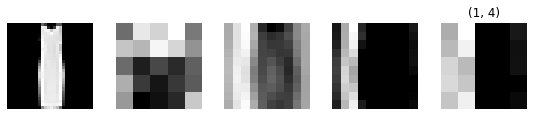

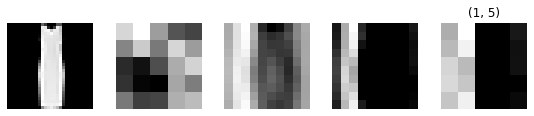

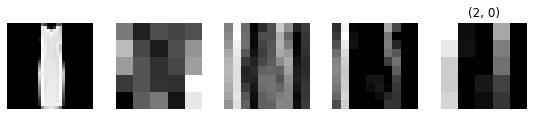

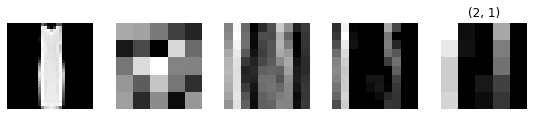

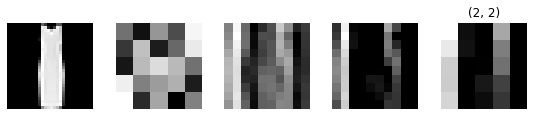

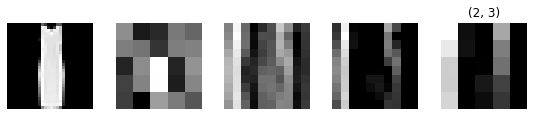

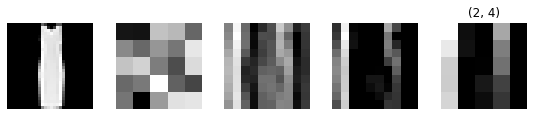

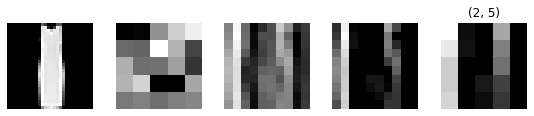

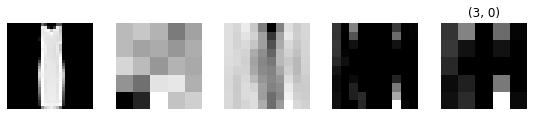

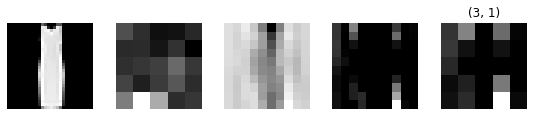

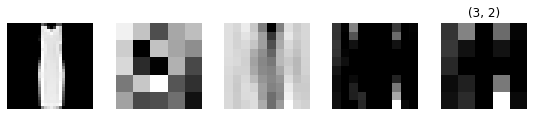

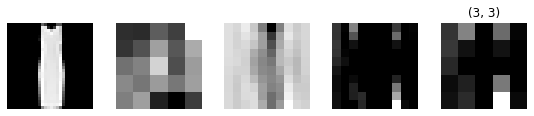

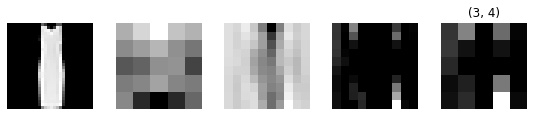

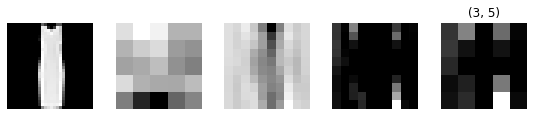

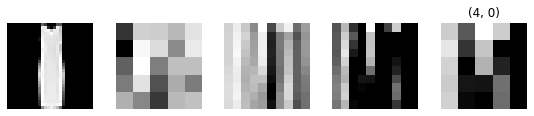

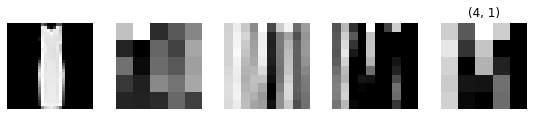

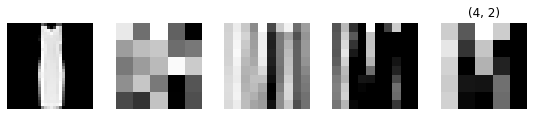

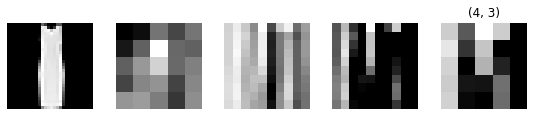

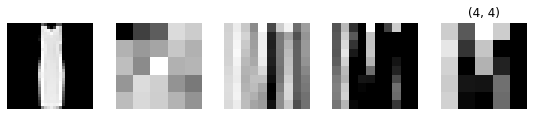

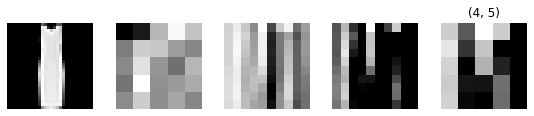

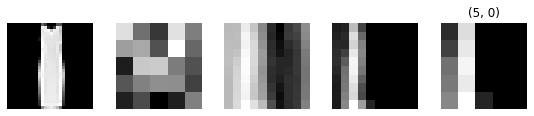

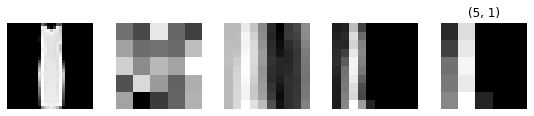

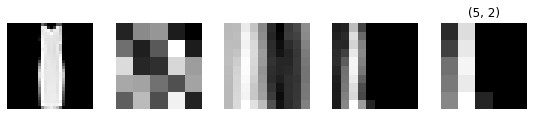

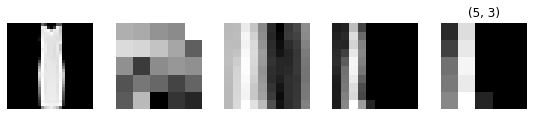

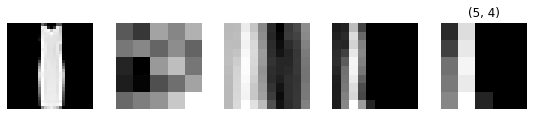

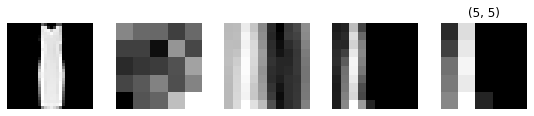

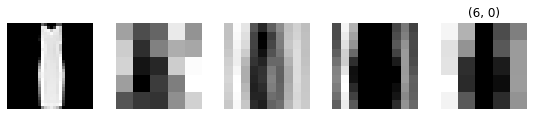

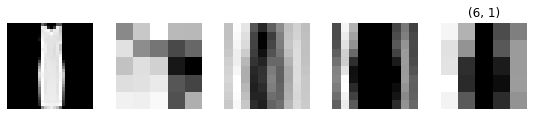

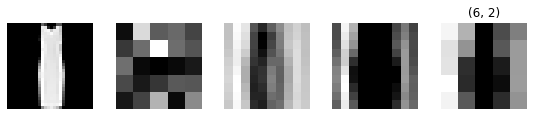

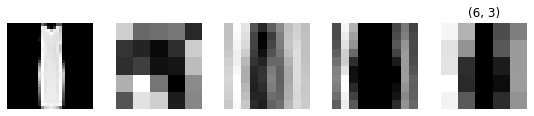

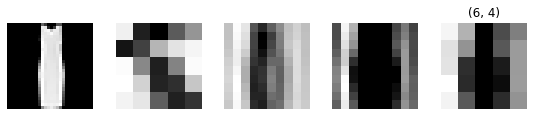

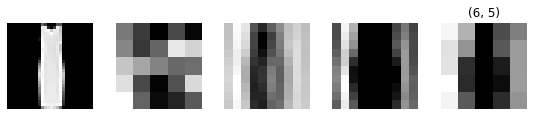

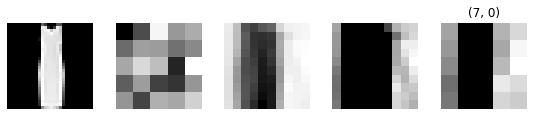

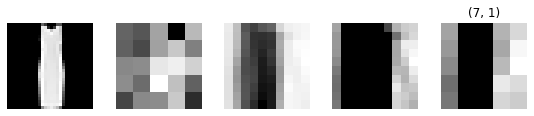

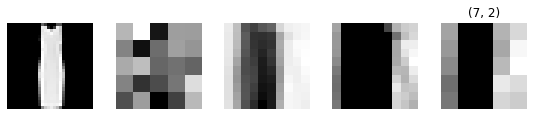

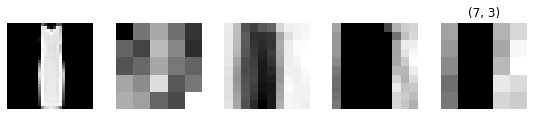

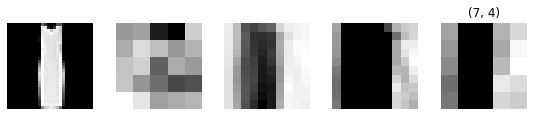

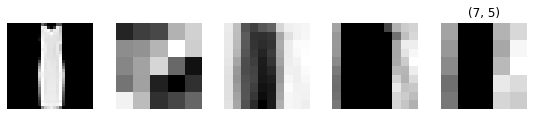

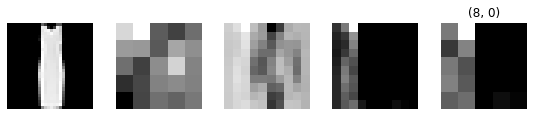

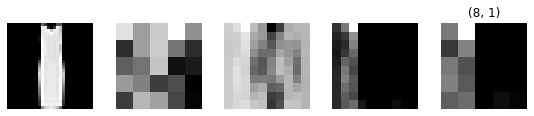

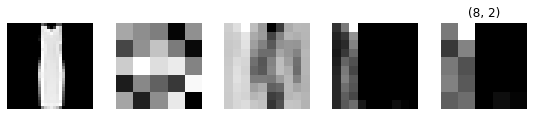

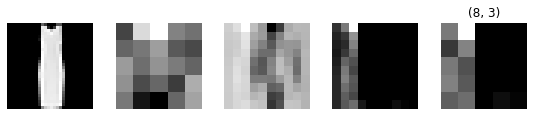

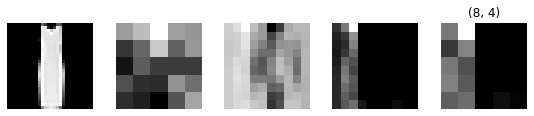

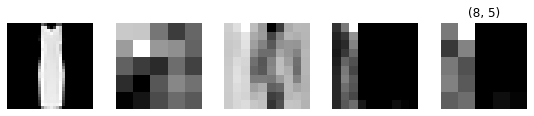

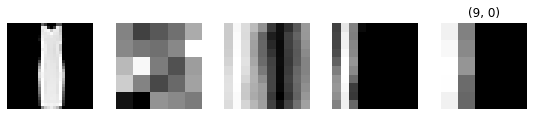

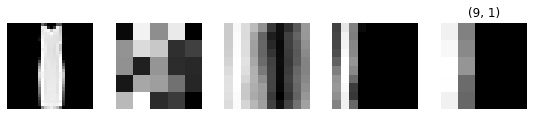

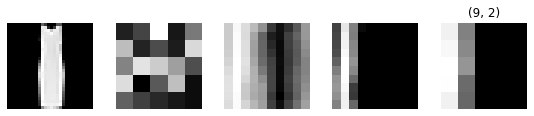

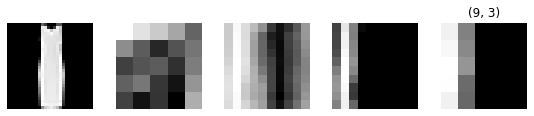

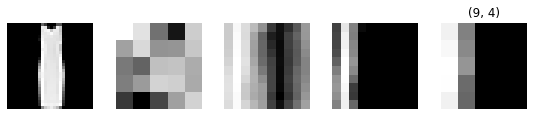

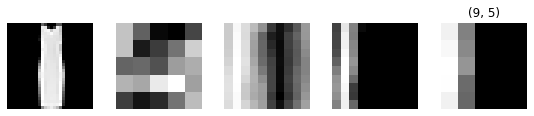

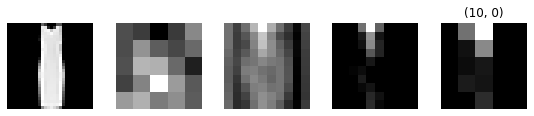

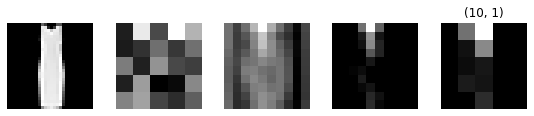

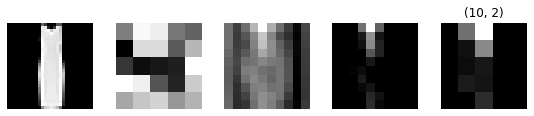

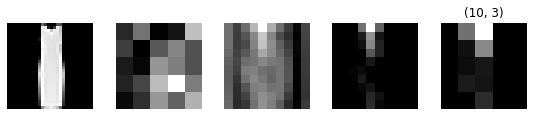

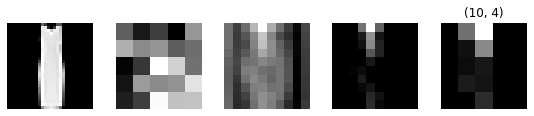

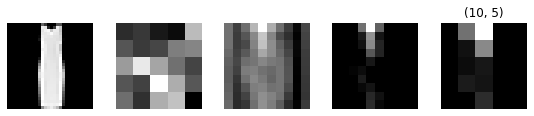

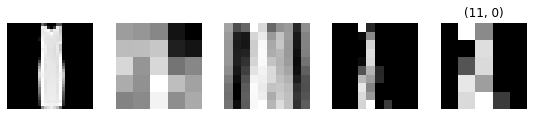

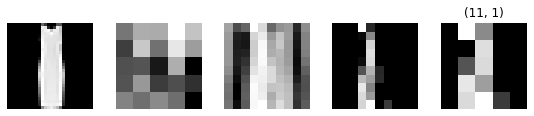

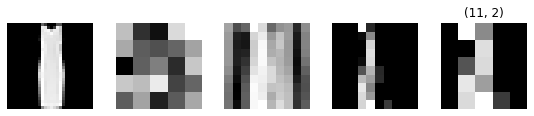

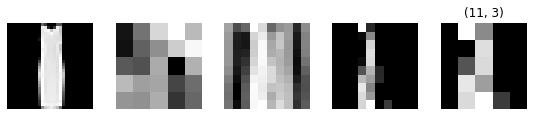

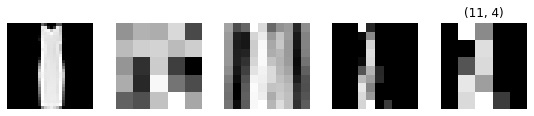

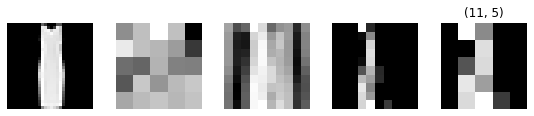

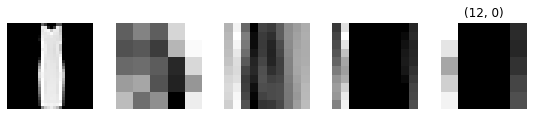

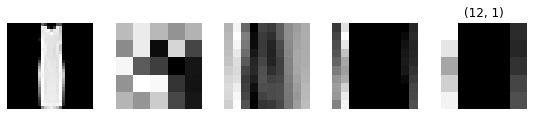

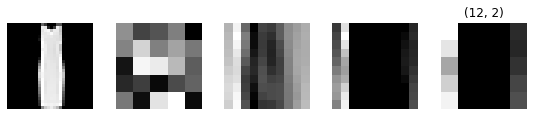

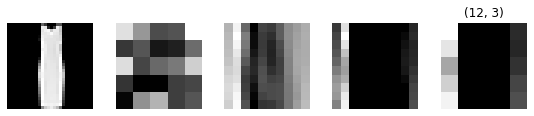

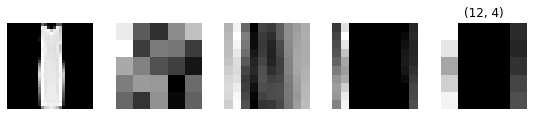

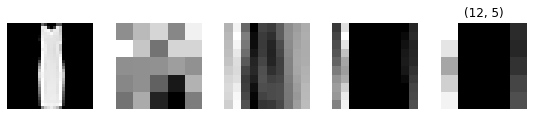

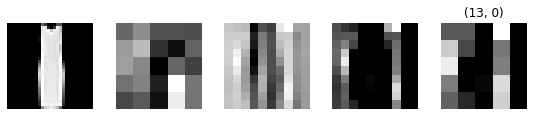

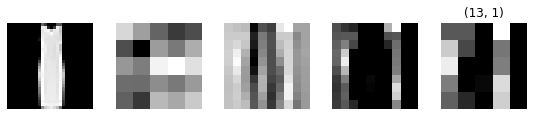

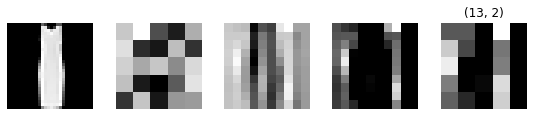

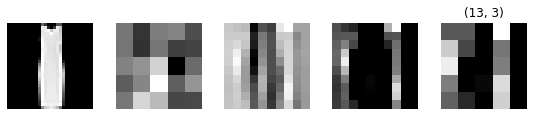

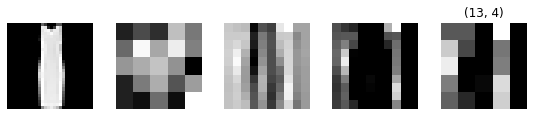

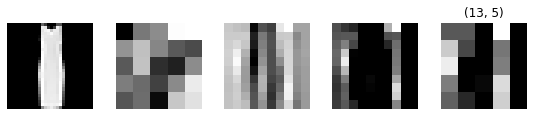

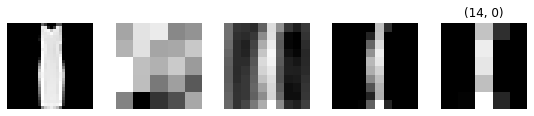

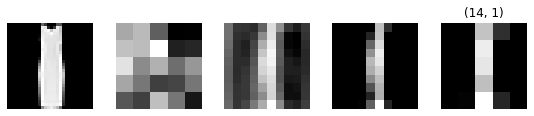

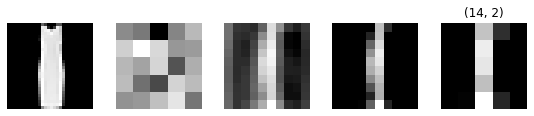

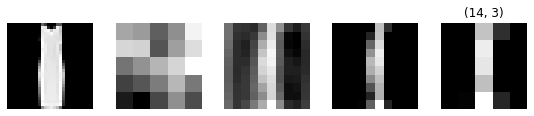

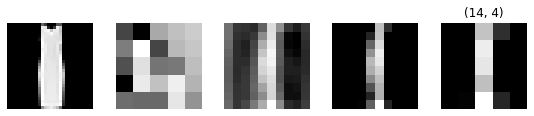

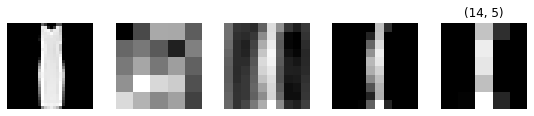

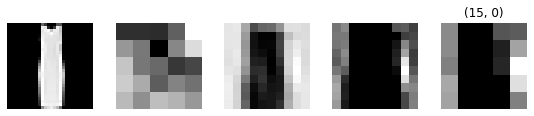

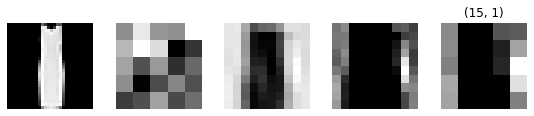

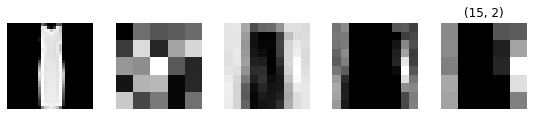

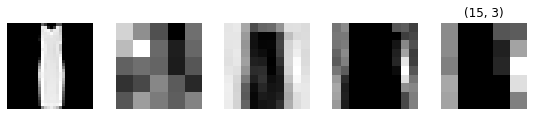

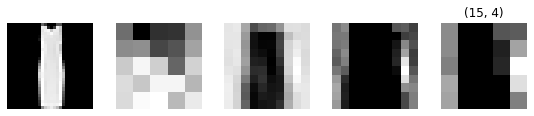

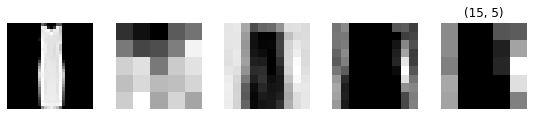

In [80]:
# this for second block
visual_block(X[23],model,4,7,2,trainer)